In [1]:
%%html
<style>
body {
    font-family: "Comic Sans MS", cursive, sans-serif;
}
</style>  

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
plt.xkcd();

In [21]:
rcParams = plt.rcParams
font_size = 14
rcParams['font.size'] = font_size
rcParams['axes.labelsize'] = font_size
rcParams['xtick.labelsize'] = font_size
rcParams['ytick.labelsize'] = font_size
rcParams['legend.fontsize'] = font_size

In [22]:
def draw_stick_figure(ax, x=.5, y=.5, radius=.03, quote=None, color='k', lw=2, xytext=(0, 20)):
    
    # draw the head
    head = plt.Circle((x, y), radius=radius, transform=ax.transAxes, 
                      edgecolor=color, lw=lw, facecolor='none', zorder=10)
    ax.add_patch(head)
    
    # draw the body
    body = plt.Line2D([x, x], [y-radius, y-(radius * 4)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(body)
    
    # draw the arms
    arm1 = plt.Line2D([x, x+(radius)], [y-(radius * 1.5), y-(radius*5)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(arm1)
    arm2 = plt.Line2D([x, x-(radius * .8)], [y-(radius * 1.5), y-(radius*5)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(arm2)
    
    # draw the legs
    leg1 = plt.Line2D([x, x+(radius)], [y-(radius * 4), y-(radius*8)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(leg1)
    leg2 = plt.Line2D([x, x-(radius*.5)], [y-(radius * 4), y-(radius*8)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(leg2)
    
    # say something
    if quote:
        ax.annotate(quote, xy=(x+radius, y+radius), xytext=xytext,
                    xycoords='axes fraction', textcoords='offset points',
                    arrowprops=dict(arrowstyle='-', lw=1))
    

# Model Comparison

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Create-models-of-different-polynomial-order" data-toc-modified-id="Create-models-of-different-polynomial-order-2">Create models of different polynomial order</a></span></li><li><span><a href="#Evaluating-the-models-with-R2" data-toc-modified-id="Evaluating-the-models-with-R2-3">Evaluating the models with R2</a></span></li><li><span><a href="#Inclusion-parameters" data-toc-modified-id="Inclusion-parameters-4">Inclusion parameters</a></span></li><li><span><a href="#Approximate-methods-for-selection" data-toc-modified-id="Approximate-methods-for-selection-5">Approximate methods for selection</a></span><ul class="toc-item"><li><span><a href="#Watanabe-Akaike-information-criterion-(WAIC)" data-toc-modified-id="Watanabe-Akaike-information-criterion-(WAIC)-5.1">Watanabe-Akaike information criterion (WAIC)</a></span></li><li><span><a href="#Leave-one-out-cross-validation" data-toc-modified-id="Leave-one-out-cross-validation-5.2">Leave-one-out cross validation</a></span></li><li><span><a href="#Approximate-model-averaging" data-toc-modified-id="Approximate-model-averaging-5.3">Approximate model averaging</a></span></li></ul></li></ul></div>

For each Bayesian model that we construct we obtain the posterior probability of having the model parameters and the model given the data. Hence there is a joint probability of having the model and the model coefficients. Think for example of various regression models with partial overlap in their model coefficients. 

Then we can write

$$\begin{eqnarray*}
p(\theta_1, \theta_2, \ldots, \theta_p, m | D)
&=& \frac{p(D|\theta_1, \theta_2, \ldots, \theta_p, m) 
p(\theta_1, \theta_2, \ldots, \theta_p, m)}
{\sum_m\int d\theta_m p(D|\theta_1, \theta_2, \ldots, \theta_p, m)
p(\theta_1, \theta_2, \ldots, \theta_p, m )}
\\
&=& \frac{\Pi_m p(D|\theta_m, m) 
p(\theta_m|m)p(m)}
{\sum_m\int d\theta_m p(D|\theta_1, \theta_2, \ldots, \theta_p, m)
p(\theta_1, \theta_2, \ldots, \theta_p, m )}
\end{eqnarray*}
$$

where we assumed that the model coefficients are independent of each other.

Integrating out the $\theta_i$ leads to the relative model credibility

$$
p(m|D) = \frac{p(D|m)p(m)}{\sum_m p(D|m)p(m)}
$$

which contains only the conditional probability of the model on the data.

The model credibility can be pairwise compared across different models leading to 
the Bayes factor

$$
\frac{p(m_1|D)}{p(m_2|D)} = \frac{p(D|m_1)p(m_1)}{p(D|m_2)p(m_2)}
$$

In principle we can use these to assess which model is the best. However, whereas model predictions often have a mild dependence on the priors, Bayes factors are very sensitive to them.

But in fact in Bayesian modeling we do not really have to select between different models since all models will have some (at least minor) credibility. Therefore rather than excluding models the preferred way is to average over all available models to get the probability of the predicted outcome conditioned purely on the data:

$$
p(\hat{y}|{\rm data}) = \sum_m p(\hat{y}|{\rm data},m)p(m|{\rm data}) 
= \sum_m\int d\theta_m p_m(\hat{y}|\theta_m,m) p_m(\theta_m|{\rm data},m) p_m(m|{\rm data})  
$$

Though theoretically extremely appealing, with many models this approach becomes rather cumbersome, and approximative methods are used to either select or to determine relative model credibilities.

To illustrate the approximate methods, we create three different models and compare their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [14]:
import pymc3 as pm
import arviz as az

## Load the data

In [5]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [6]:
df['american'] = df.origin.map(lambda x: 1 if x == 1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x == 2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x == 3 else 0)

american_mpg = df.mpg[df.american == 1]
european_mpg = df.mpg[df.european == 1]
asian_mpg = df.mpg[df.asian == 1]

In [7]:
target = 'mpg'
y = df[target]

In [8]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [9]:
scaler = StandardScaler()
predictors = scaler.fit_transform(df[['horsepower']])

## Create models of different polynomial order

In [10]:
poly = {}
poly_predictors = {}
for i in range(1, 4):
    poly[i] = PolynomialFeatures(degree=i, include_bias=False)
    poly_predictors[i] = poly[i].fit_transform(predictors)
    print(i, poly[i].get_feature_names())

1 ['x0']
2 ['x0', 'x0^2']
3 ['x0', 'x0^2', 'x0^3']


In [15]:
i = 2
model = {}
for i in range(1, 4):
    with pm.Model() as model[i]:
        prior_std = 10
        std = pm.HalfCauchy('error_std', beta=10)
        intercept = pm.Normal('intercept', mu=0., sd=prior_std)
        beta = pm.Normal('beta', mu=0., sd=prior_std,
                         shape=poly_predictors[i].shape[1])
        y_hat = pm.Normal('y_hat',
                          mu=intercept+pm.math.dot(poly_predictors[i], beta),
                          sd=std,
                          observed=y.values)

In [16]:
model

{1: <pymc3.model.Model at 0x1c1f60f8d0>,
 2: <pymc3.model.Model at 0x1c207fdf60>,
 3: <pymc3.model.Model at 0x1c20bb5da0>}

In [17]:
trace = {}
for i in range(1, 4):
    with model[i]:
        trace[i] = pm.sample(5000, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2664.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:12<00:00, 983.29draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:17<00:00, 651.18draws/s]


In [18]:
trace[1][0]

{'error_std_log__': 1.5883967562275985,
 'intercept': 23.994889515956505,
 'beta': array([-6.0211102]),
 'error_std': 4.895893322304243}

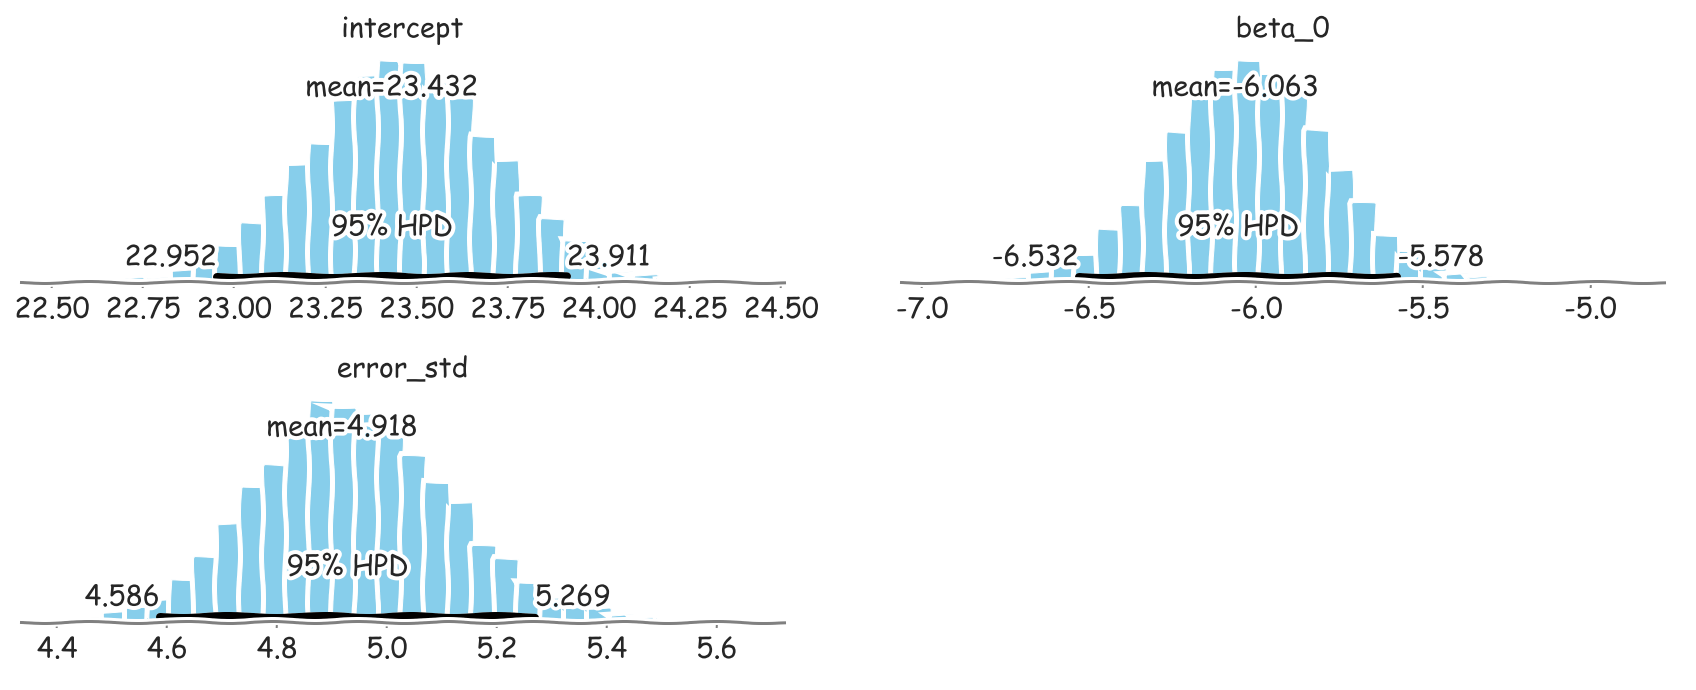

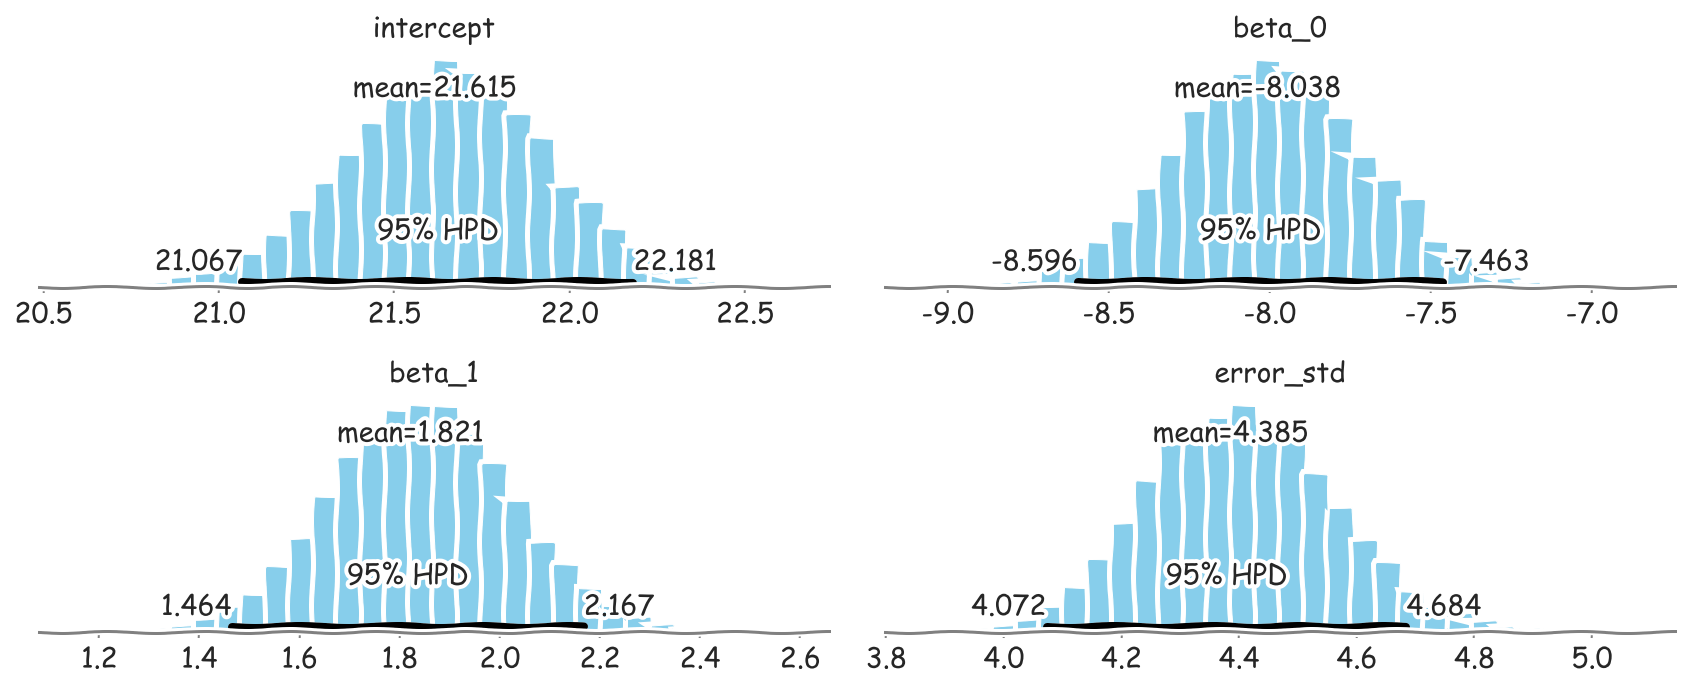

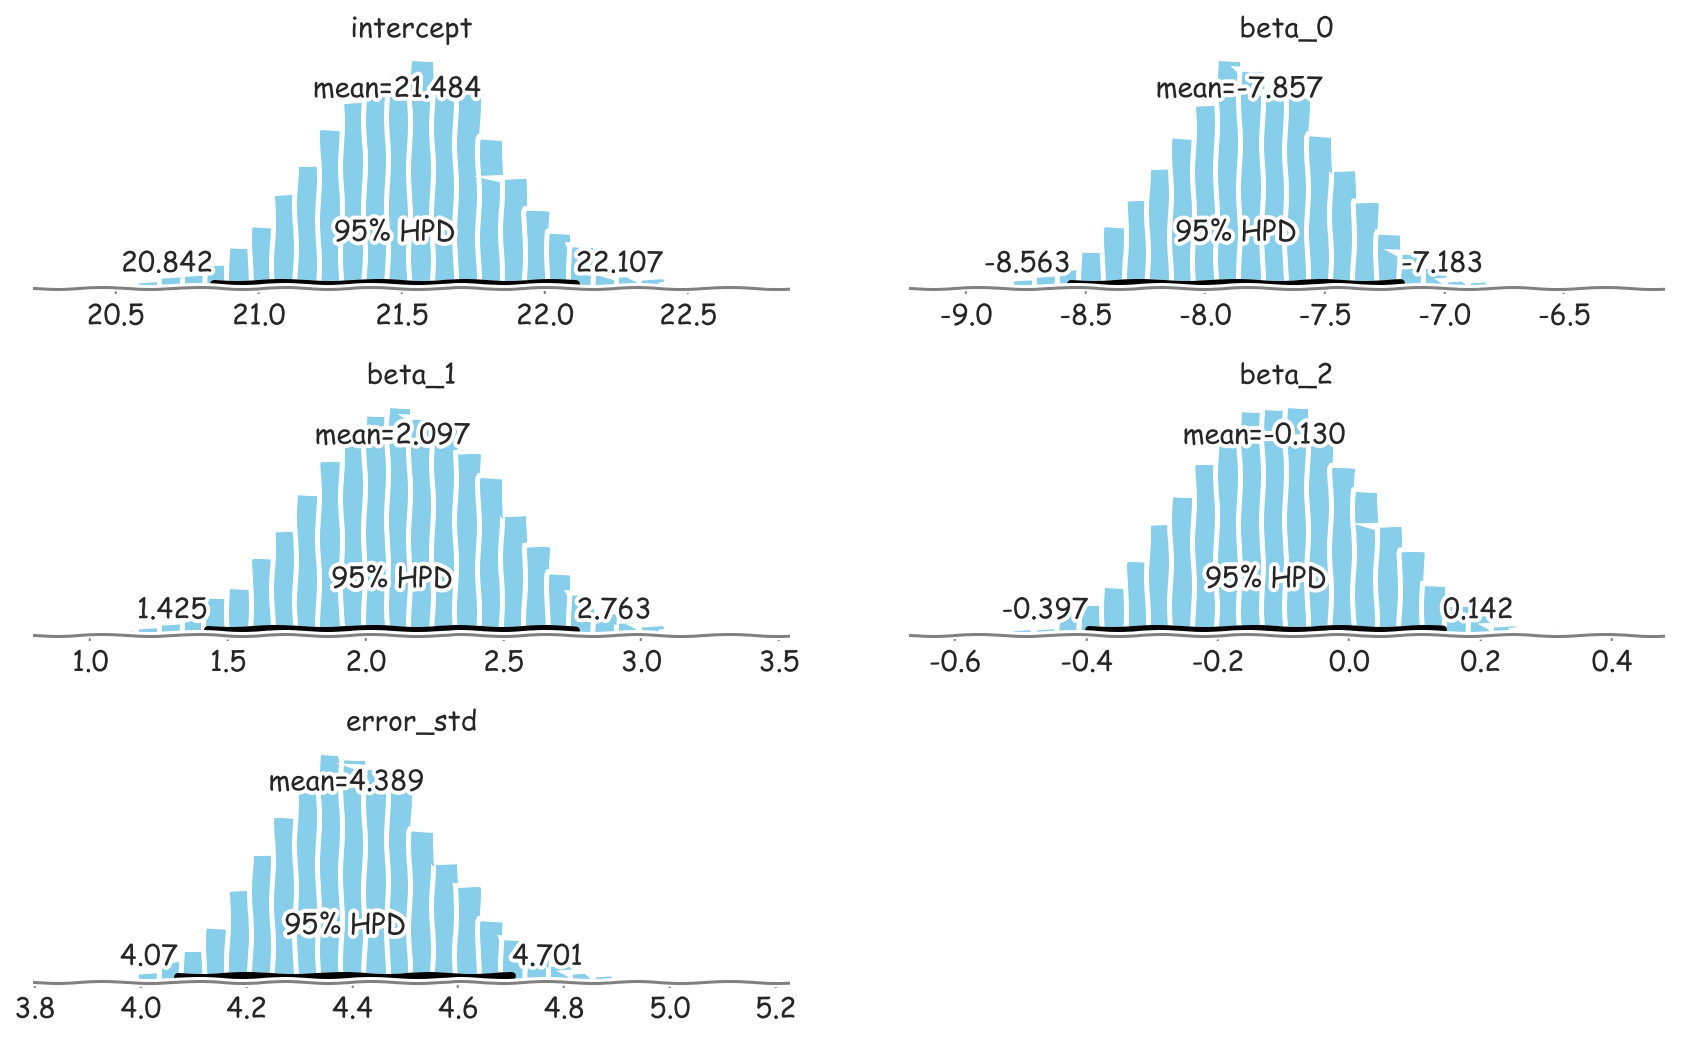

In [19]:
for i in range(1, 4):
    pm.plot_posterior(trace[i])
plt.show()

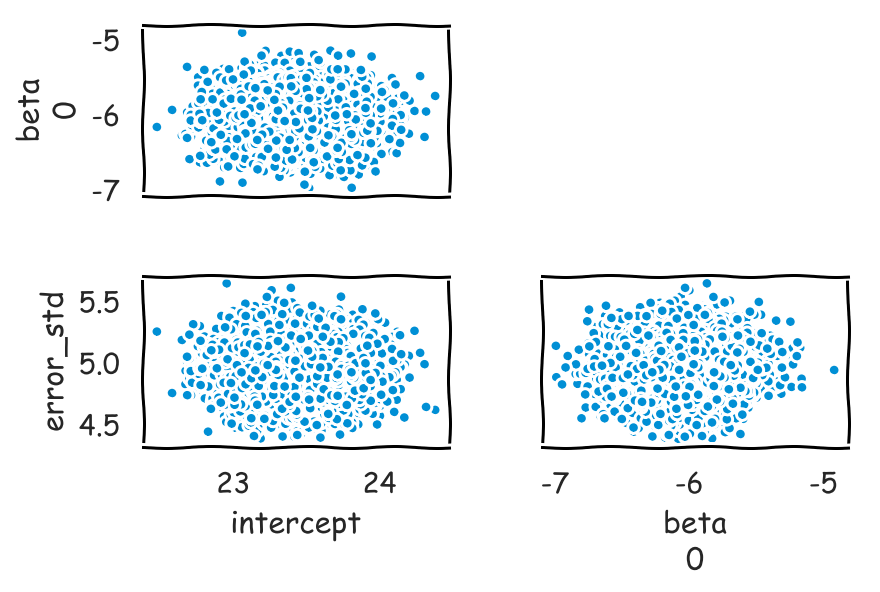

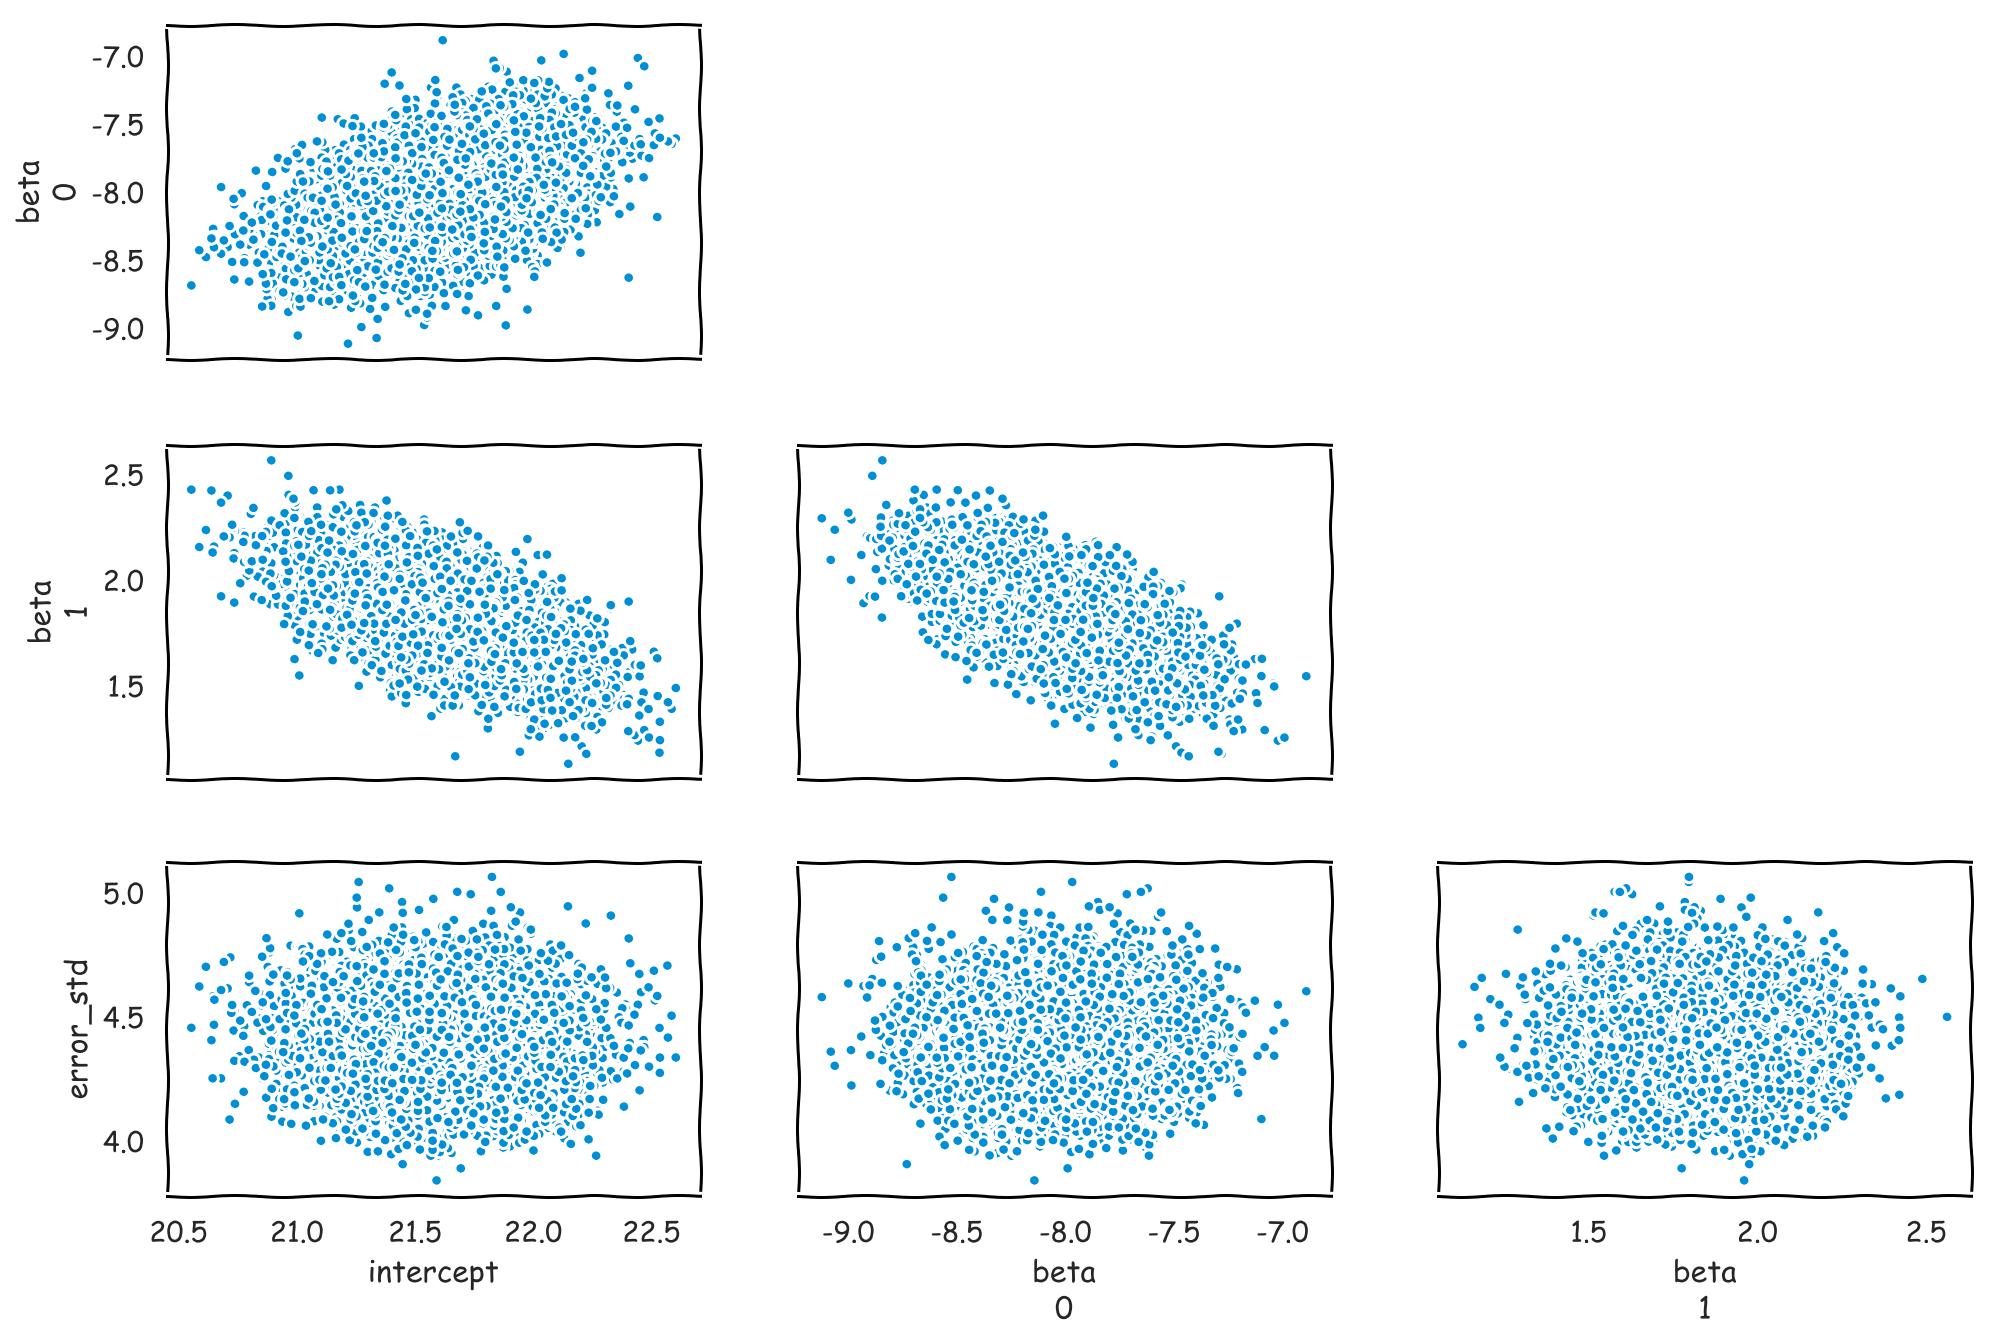

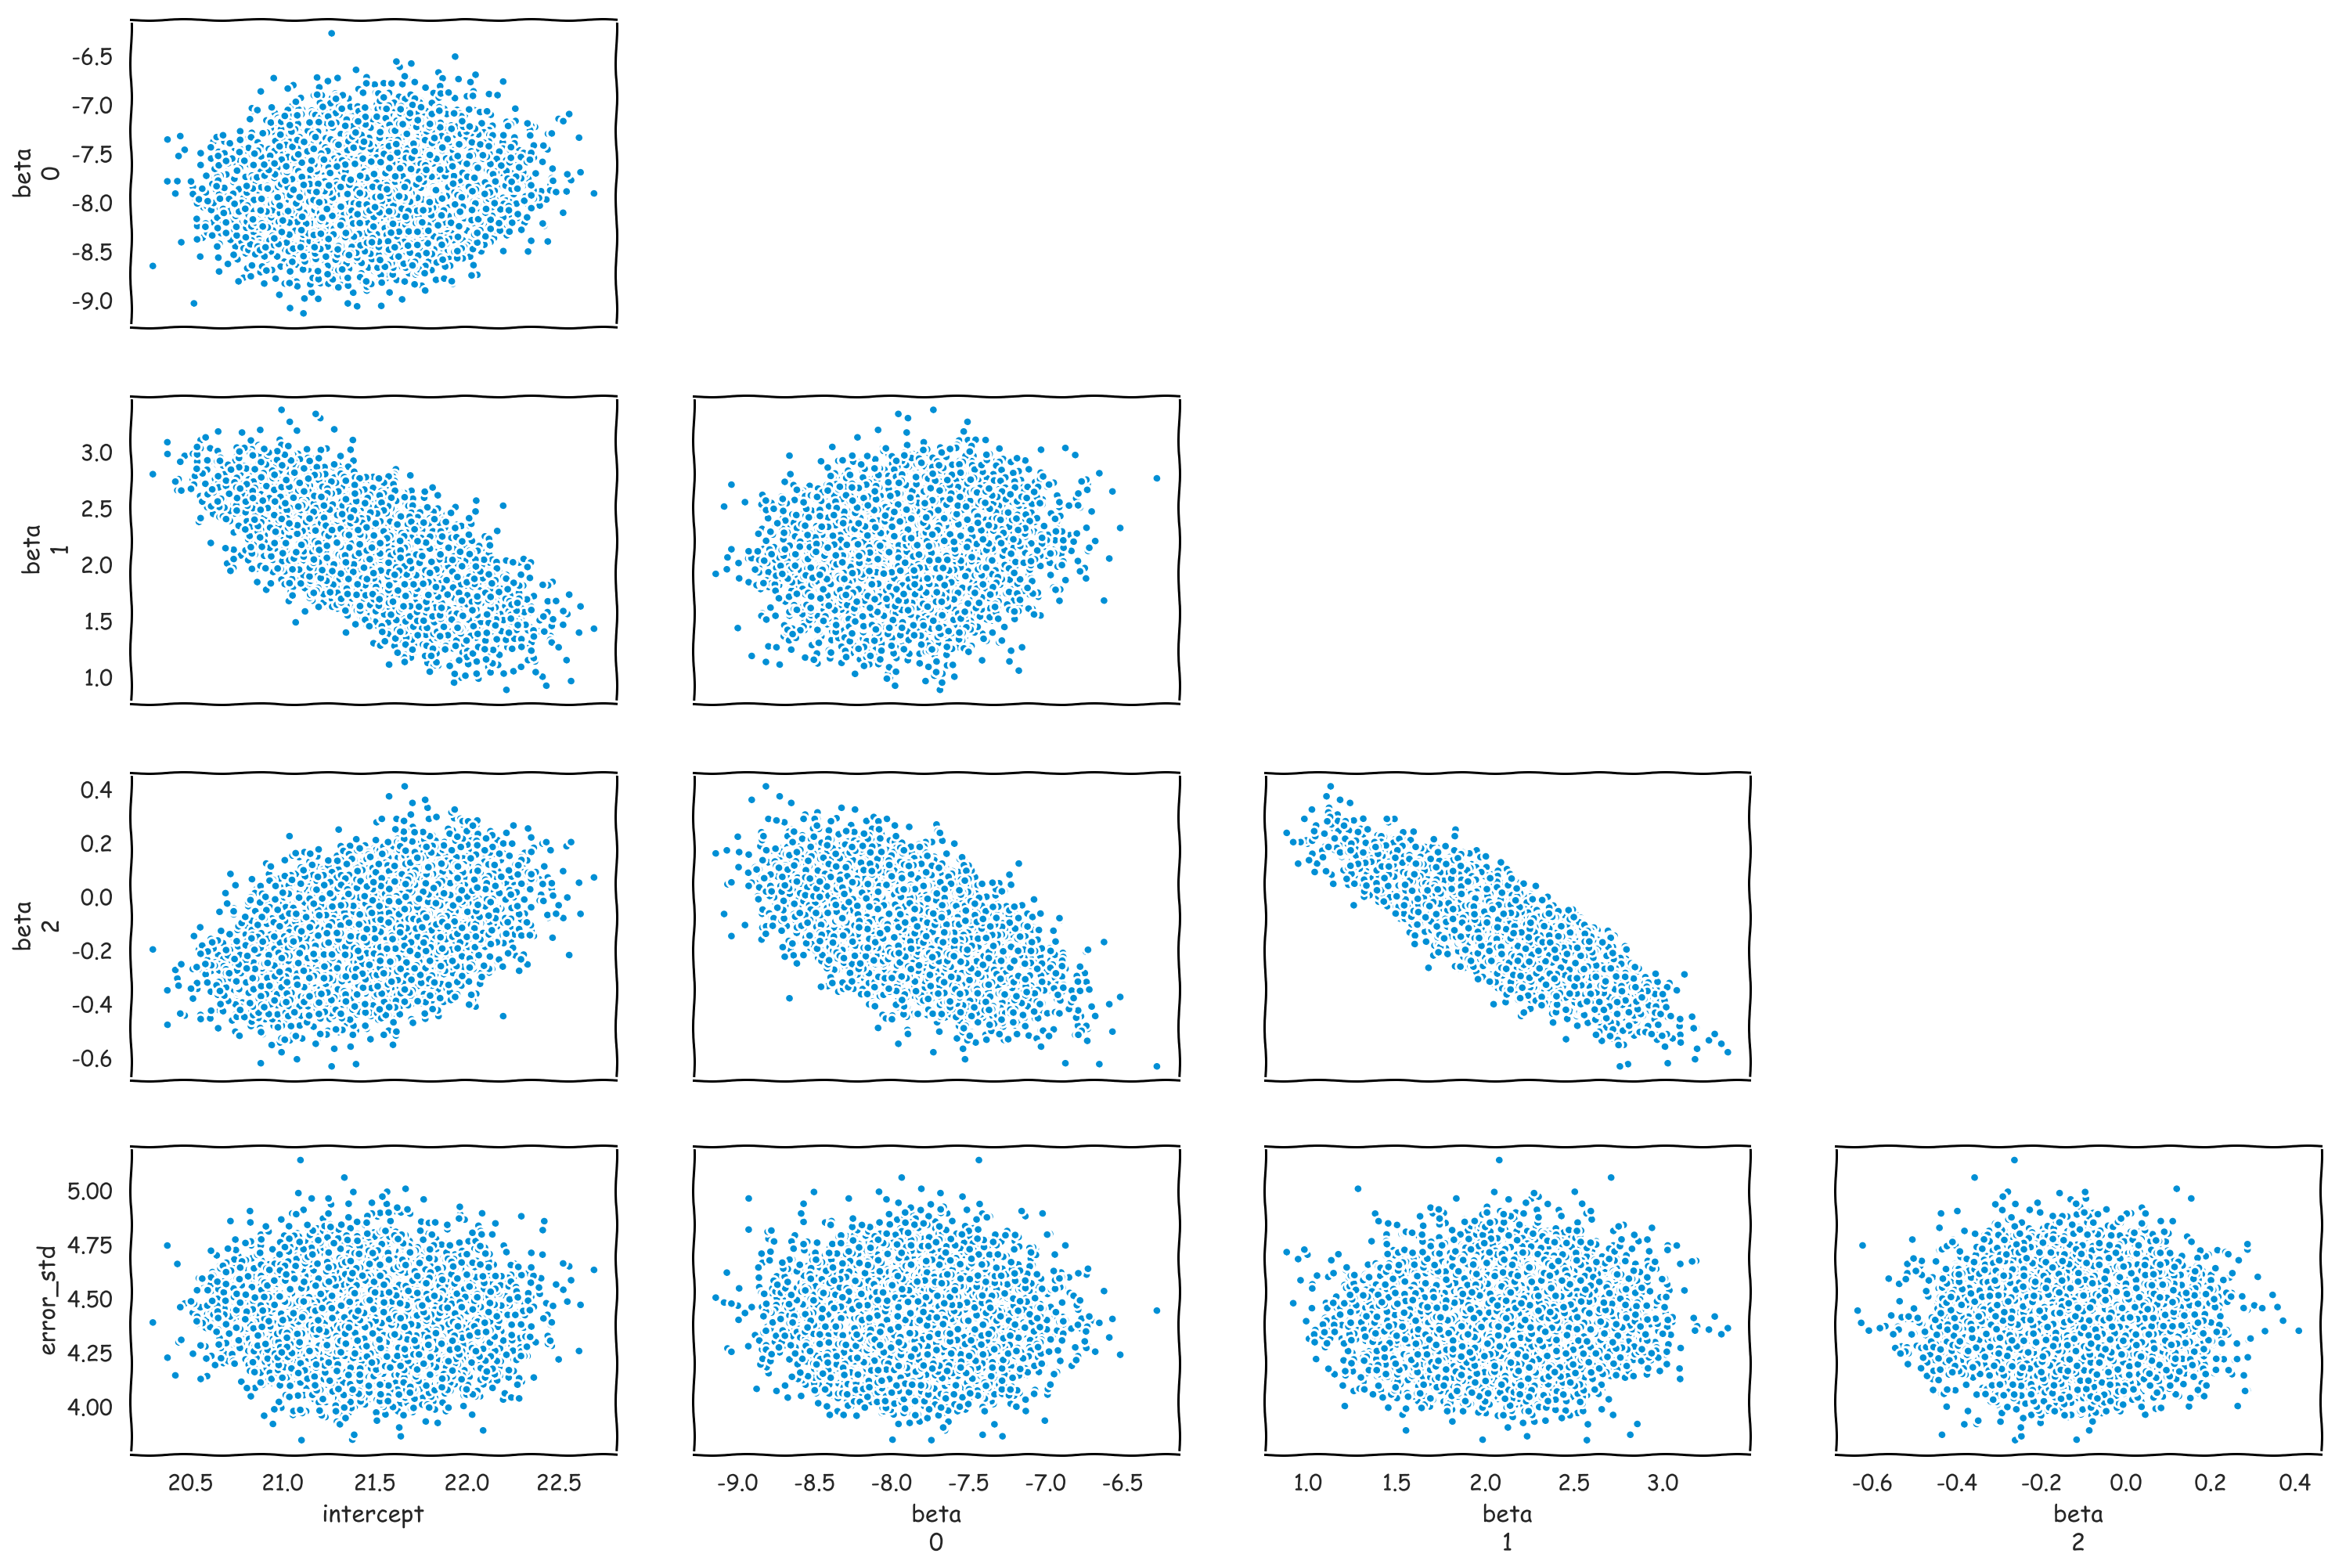

In [20]:
for i in range(1, 4):
    az.plot_pair(trace[i])
plt.show()

In [15]:
model

{1: <pymc3.model.Model at 0x1c29d984a8>,
 2: <pymc3.model.Model at 0x1c2e15be10>,
 3: <pymc3.model.Model at 0x1c2e3b5860>}

In [16]:
trace

{1: <MultiTrace: 2 chains, 5000 iterations, 4 variables>,
 2: <MultiTrace: 2 chains, 5000 iterations, 4 variables>,
 3: <MultiTrace: 2 chains, 5000 iterations, 4 variables>}

## Evaluating the models with R2

In [17]:
for i in model.keys():
    preds = pm.sample_posterior_predictive(
        trace[i], model=model[i], samples=1000)
    print(i, pm.r2_score(y.values, preds['y_hat'], round_to=6).r2_mean)

  6%|▌         | 62/1000 [00:00<00:01, 617.66it/s]

1 0.558818


 22%|██▏       | 224/1000 [00:00<00:00, 870.94it/s]

2 0.613514


100%|██████████| 1000/1000 [00:01<00:00, 1002.89it/s]

3 0.613578


## Inclusion parameters

A way to test for credibility of different  models is to include all of them into a single model and to allow for switching between different models. This can usually be achieved by creating an hierarchical structure with the model choice at the top. In regression, the construction is simpler. We can insert additional binary coefficients set at each iteration step as a decision to include or not to include any of the regression factors.

In [18]:
with pm.Model() as model_s1:
    intercept = pm.Normal('intercept', mu=df[target].mean(), sd=10*prior_std)
    beta = pm.Normal('beta', mu=0., sd=10*prior_std,
                     shape=poly_predictors[i].shape[1])
    delta = pm.Bernoulli('delta', [0.5, 0.5, 0.5],
                         shape=(poly_predictors[i].shape[1]))

    mu = intercept + pm.math.dot(delta*beta, poly_predictors[i].T)
    sigma = pm.Uniform('sigma', 10**(-5), 10)

    likelihood = pm.Normal('likelihood', mu=mu, sd=sigma,
                           observed=df[target].values)

In [19]:
with model_s1:
    trace_s1 = pm.sample(draws=5000, tune=2000, nuts_kwargs={
                         'target_accept': 0.95})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, beta, intercept]
>BinaryGibbsMetropolis: [delta]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:07<00:00, 207.85draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [20]:
pm.summary(trace_s1)

mean          sd  mc_error     hpd_2.5    hpd_97.5  \
intercept  21.637468    0.288665  0.004289   21.064255   22.192613   
beta__0    -8.029721    0.295816  0.004617   -8.626301   -7.475309   
beta__1     1.813575    0.180781  0.002933    1.457011    2.157652   
beta__2    -1.409088  100.488210  1.341069 -191.462167  204.693844   
delta__0    1.000000    0.000000  0.000000    1.000000    1.000000   
delta__1    1.000000    0.000000  0.000000    1.000000    1.000000   
delta__2    0.001800    0.042388  0.001330    0.000000    0.000000   
sigma       4.388938    0.159035  0.001522    4.081554    4.705897   

                  n_eff      Rhat  
intercept   4125.784304  1.000065  
beta__0     3270.622204  1.000411  
beta__1     3239.654234  1.000060  
beta__2     7025.414899  0.999910  
delta__0            NaN       NaN  
delta__1            NaN       NaN  
delta__2     697.534240  1.001326  
sigma      10197.003732  0.999910

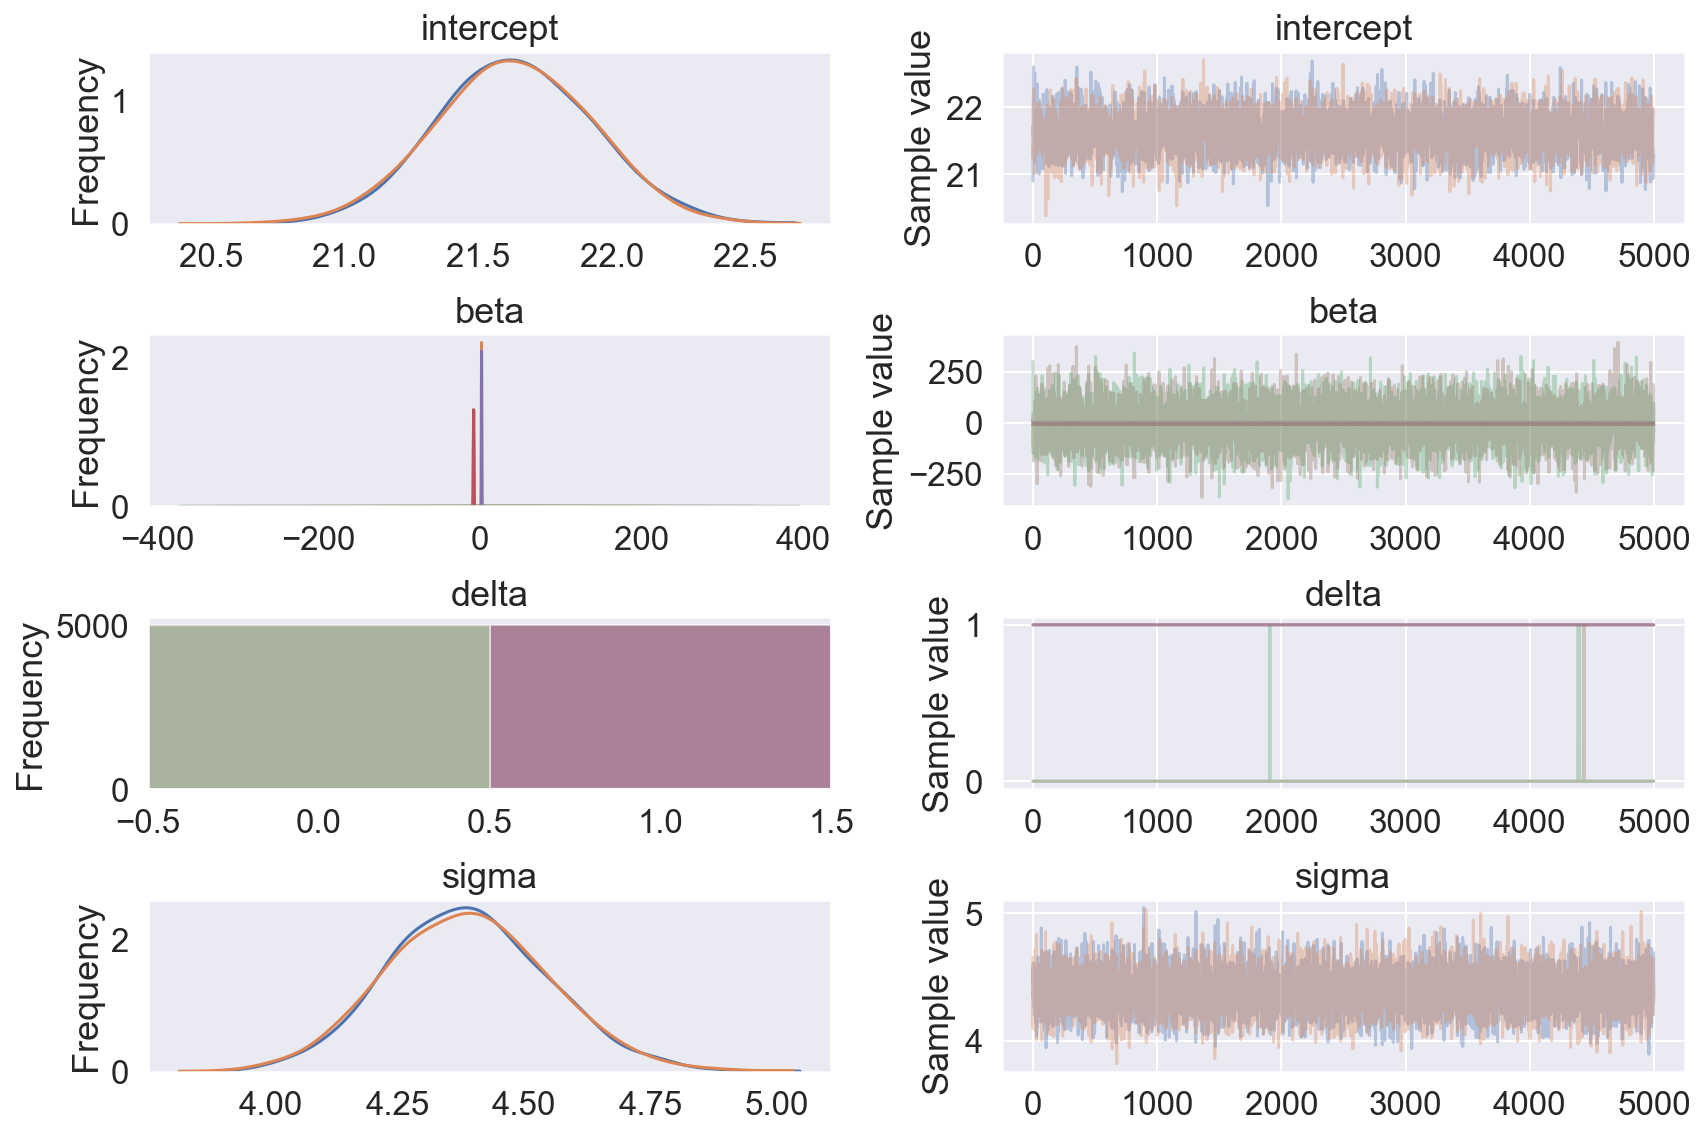

In [21]:
pm.traceplot(trace_s1)
plt.show()

In [22]:
trace_s1['delta'].sum(axis=0)

array([10000, 10000,    18])

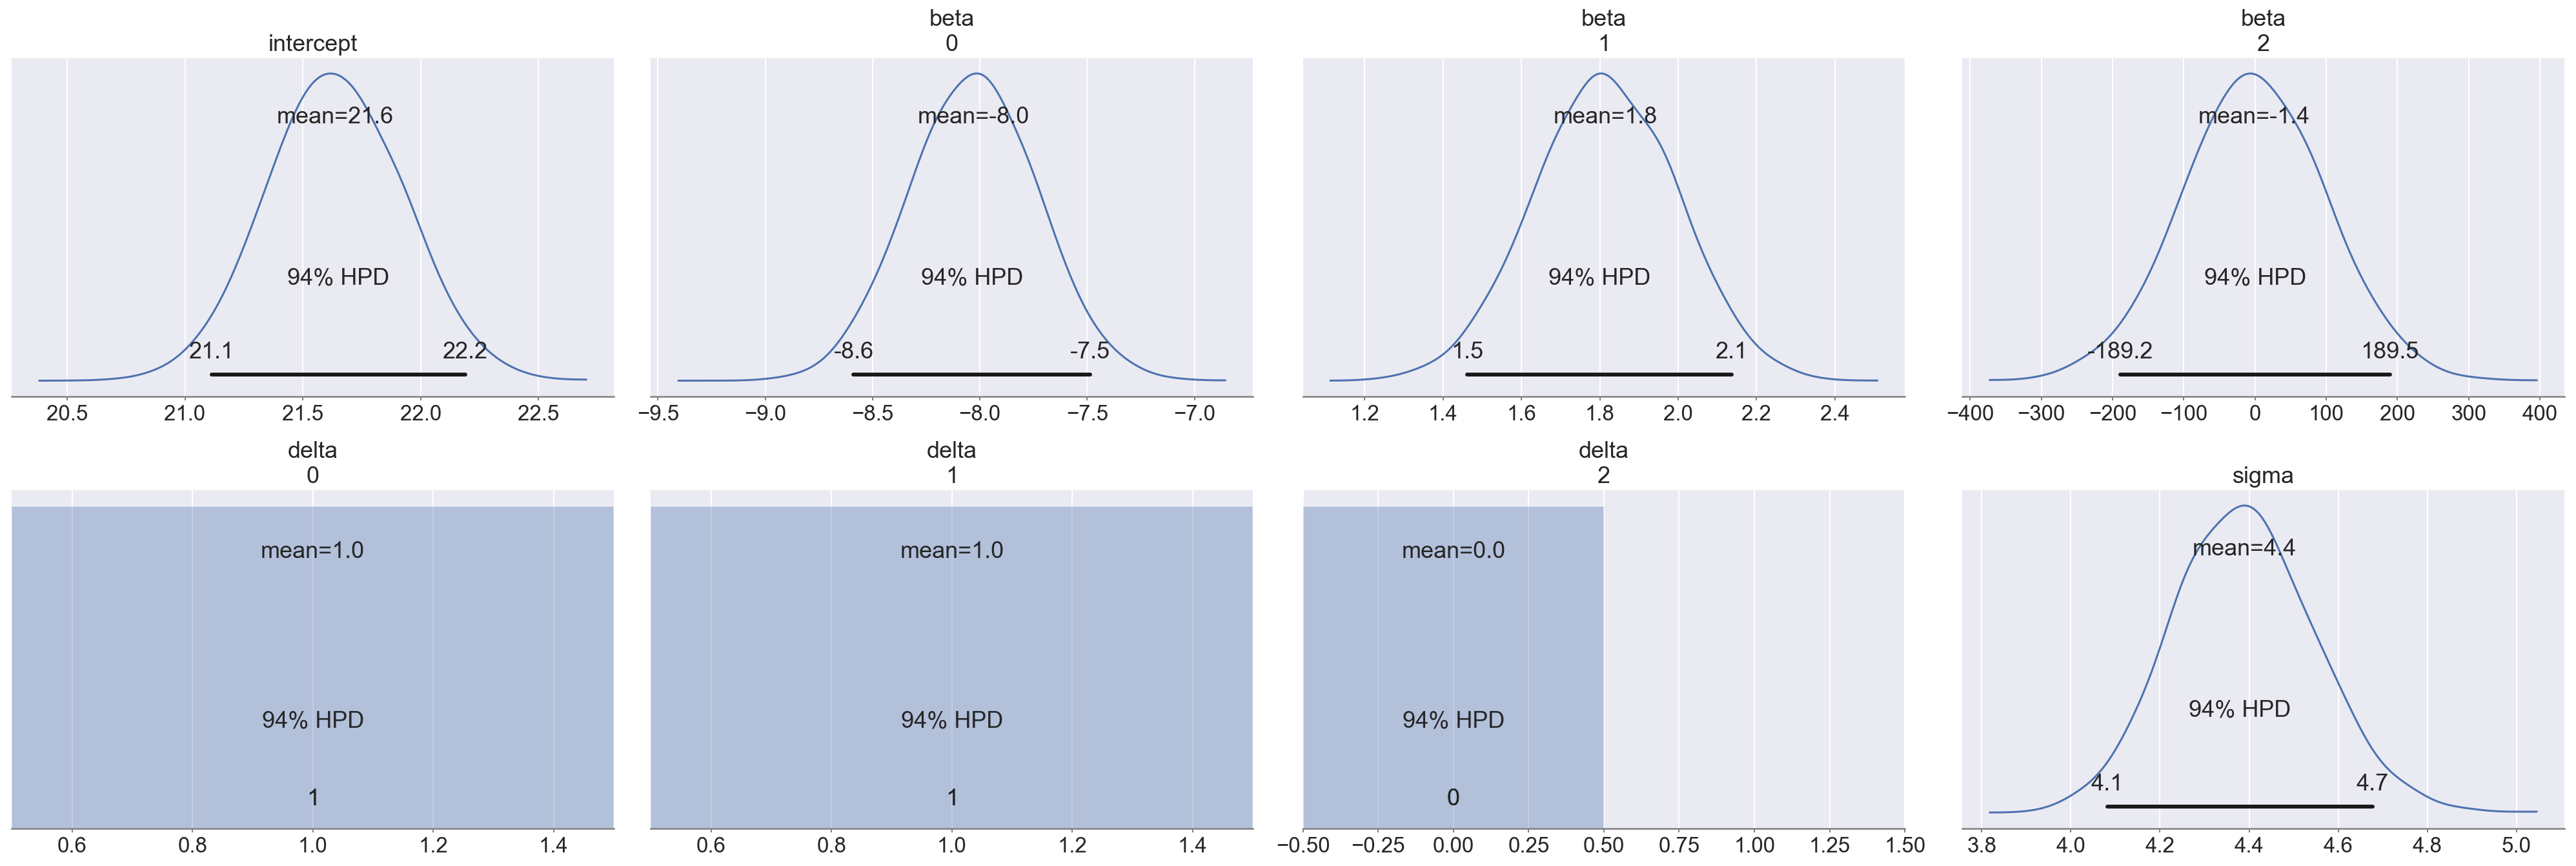

In [23]:
az.plot_posterior(trace_s1)
plt.show()

## Approximate methods for selection

The above approach is appealing, but poses many numerical challenges.
Some approximate methods can help for model selection. They provide single numbers according to which models can be ranked, the smaller the better. They are not a replacement for careful posterior checks if the model matches the data and generalizes to new data.

Most of the criteria make assumptions for large sample sizes under quite generic conditions. Versions of the central limit theorem for the likelihood function play a role here since the likelihood function dominates over any prior information for large samples.

### Watanabe-Akaike information criterion (WAIC)

The WAIC, also called the "widely applicable information criterion", is a fully Bayesian information criterion for estimating the capability of a model to generalize to unseen data.
The smaller the score, the better it is. We can calculate it with the function `pm.compare()`
applied to an iterator over different models and traces.

The table returns 

- 1st column: the WAIC score 
- 2nd column: a measure of the effective number of degrees of freedom in the model
- 3rd column: difference of WAIC to best model (always 0 for best model)
- 4th column: approximate model weight for model averaging
- 5th/6th column: standard errors for WAIC and difference between them
- 7th column: warning when signs of non-reliability

In [24]:
comp_WAIC = pm.compare(dict(zip(model.values(), trace.values())), ic='WAIC')
comp_WAIC

/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC pWAIC  dWAIC weight     SE    dSE var_warn
1  2274.81  4.32      0      0  36.21      0        0
2  2276.28  5.59   1.47   0.89  36.89   2.38        1
0  2363.79  3.42  88.98   0.11  30.23  20.71        0

In the last column there is a warning indicated for the third model. That is why there is the complaint.

In [25]:
pm.waic(trace[3], model=model[3])

/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=2276.2814922601965, WAIC_se=36.88652247511233, p_WAIC=5.587663792929051, var_warn=1)

### Leave-one-out cross validation

This approach is based on cross validation where each point forms once the test set while the remaining ones form the training set. However, here pymc3 does not really perform cross validation but uses approximate formulas to estimate the cross validation error which exist for this particular type of cross validation. We obtain a similar table as for WAIC. 
In this case, the results are nearly identical to the WAIC. There are asymptotic results for large sample sizes so that this is not a coincidence. Versions with further refinement are available.

In [26]:
comp_LOO = pm.compare(dict(zip(model.values(), trace.values())), ic='LOO')
comp_LOO

LOO  pLOO   dLOO weight     SE    dSE shape_warn
1  2274.82  4.33      0      0  36.21      0          0
2  2276.29  5.59   1.48   0.89  36.89   2.38          0
0  2363.79  3.42  88.98   0.11  30.23  20.71          0

We can depict these results graphically.

- The empty dots mark the scores
- The dashed line indicates the score of the best model
- The horizontal lines indicate the standard error (of score around filled dot and difference of scores around triangle)
- The filled dots are 2 times the effective number of degrees of freedom subtracted from the score

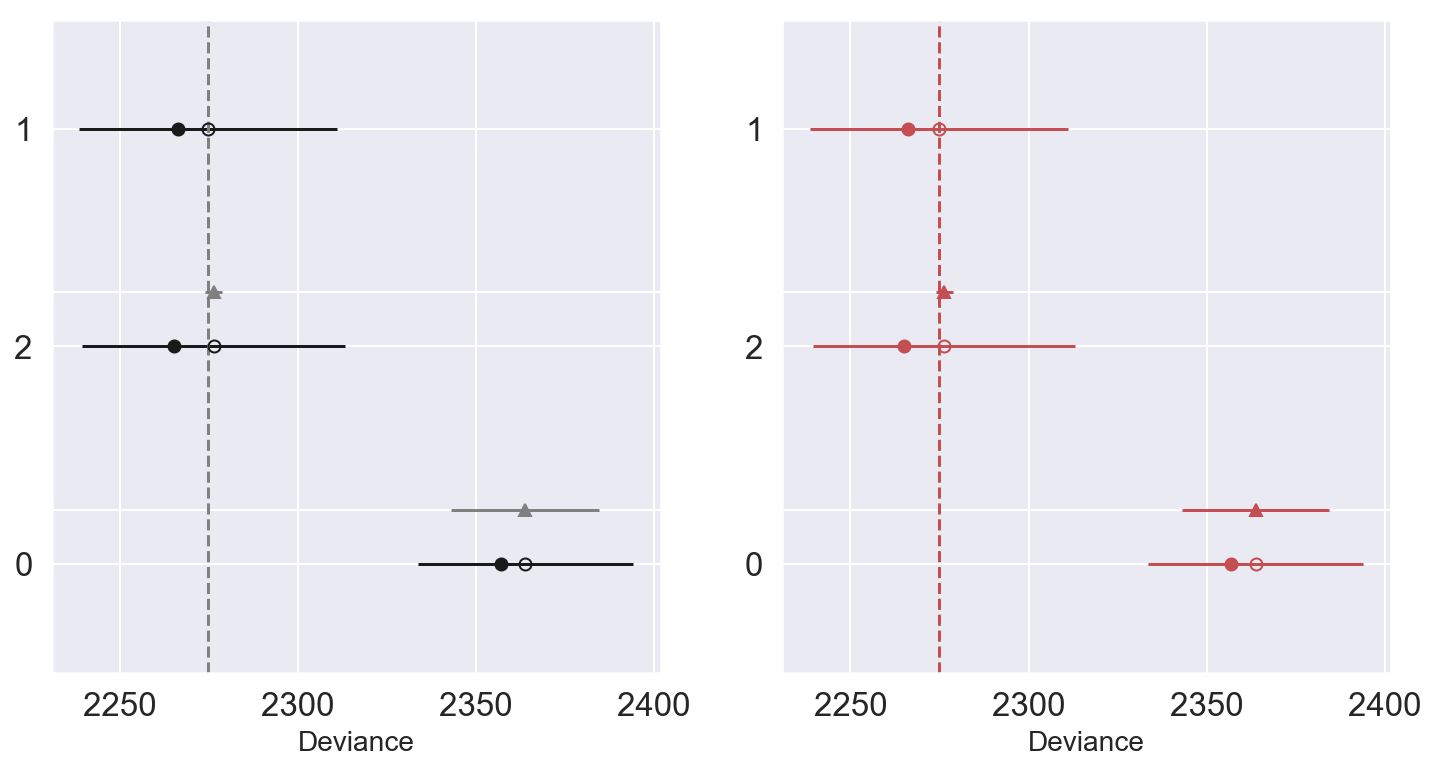

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
pm.compareplot(comp_WAIC, ax=ax[0])
pm.compareplot(comp_LOO, ax=ax[1], plot_kwargs={
               'color_ic': 'r', 'color_insample_dev': 'r', 'color_dse': 'r', 'color_ls_min_ic': 'r'})
plt.show()

### Approximate model averaging

We mentioned above that we would ideally like to create a weighted version of all the models.
Also this can be done in approximate form by making use of the weights produced with the scores.

First we generate the posterior predictive samples for each model.

In [29]:
sample_ppc = [pm.sample_posterior_predictive(trace[i], 1000, model[i])[
    'y_hat'] for i in range(1, 4)]

100%|██████████| 1000/1000 [00:00<00:00, 1523.69it/s]


Then we generate the posterior predictive samples from the weighted combination of models.

In [30]:
weights = comp_LOO.weight.sort_index().values

weighted_ppc = pm.sample_posterior_predictive_w(
    list(trace.values()), 1000, list(model.values()), weights=weights)['y_hat']

100%|██████████| 1000/1000 [00:01<00:00, 951.95it/s]


Arviz' kdeplot can be used to create the following plots.

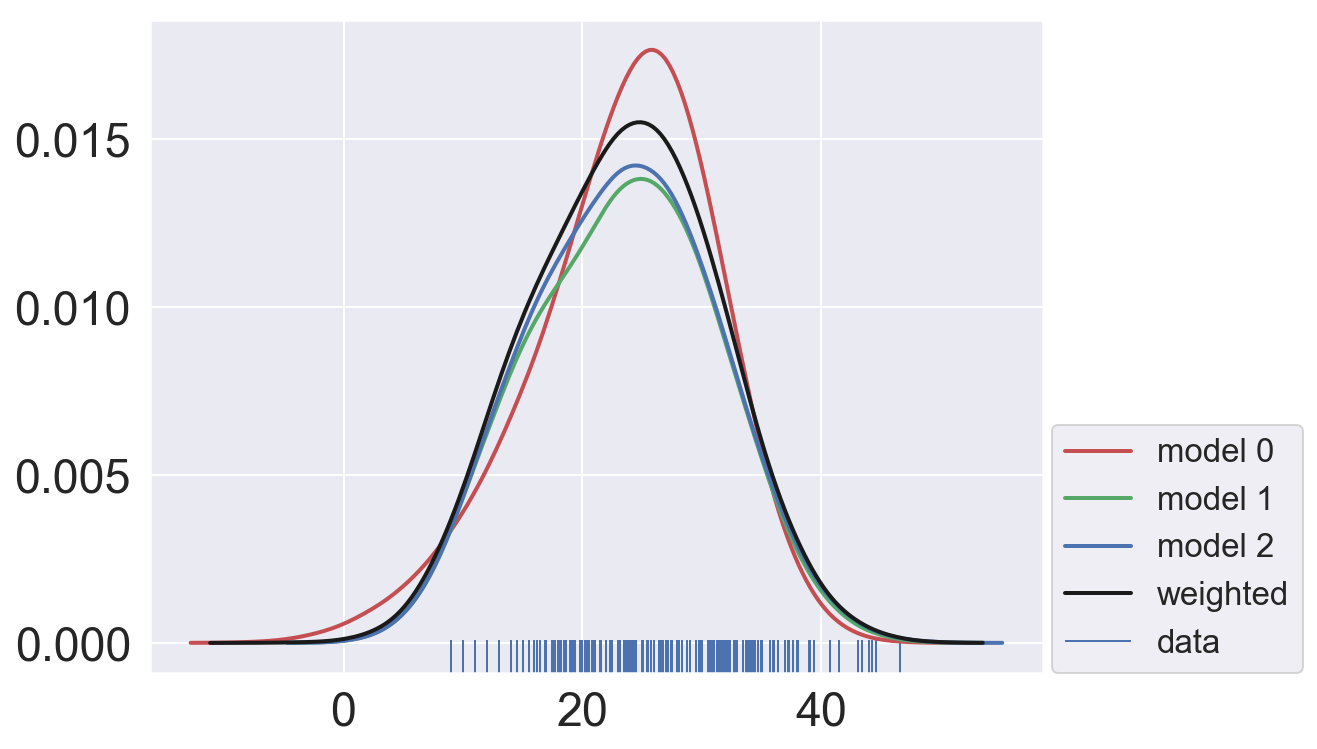

In [31]:
plt.figure(figsize=(8, 6))
for i, color in zip(list(range(3)), ['r', 'g', 'b']):
    az.plot_kde(sample_ppc[i], label='model {}'.format(
        i), plot_kwargs={'color': color, 'linewidth': 2})
az.plot_kde(weighted_ppc, plot_kwargs={
            'color': 'k', 'linewidth': 2}, label='weighted')
sns.rugplot(y, label='data')
plt.legend(loc=[1.01, 0])
plt.show()